<a href="https://colab.research.google.com/github/Lima-Ricardo/Analise-Pandas-Pyspark-GCP/blob/main/Pandas_e_XML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pegar a base de dados da Alesp(assembleia legislativa de são paulo) e realizar os tratamentos necessários com as seguintes diretrizes:
Utilizar obrigatoriamente pandas 
Extrair diretamente do site o arquivo XML dos gastos e cadastros de cada deputado
Verificar e corrigir possíveis inconsistências nos dados que podem ser (Nomes diferentes para o mesmo item ex: TÁXI e taxi ) ou valores ausentes ou duplicidade de dados
verificar e contar os valores ausentes (NaN , NA , etc)
realizar insights onde mostrem os valores totais dos ultimos 4 anos dos valores gastos por cada deputado
mostrar os itens dos ultimos quatro anos onde se mais teve despesa 
mostrar os 3 deputados que mais e menos gastam
realizar a conversão do dataframe para CSV e disponibiliza-lo em um bucket com acesso público
Os insights não se limitam aos pedidos acima , onde gostaríamos de pelo menos mais 2 
Os resultados podem ou não trazer plotagem(trate como não obrigatório ) mas é recomendado que traga
Montar uma pequena apresentação no próprio notebook trazendo uma organização e fluxo de ETL**

In [ ]:
!pip install pandas

In [ ]:
!pip install numpy

In [ ]:
!pip install gcsfs

In [ ]:
import pandas as pd
import numpy as np
import requests
import warnings
from google.cloud import storage
import os


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# URL da API da Alesp
URL_Despesas = 'http://www.al.sp.gov.br/repositorioDados/deputados/despesas_gabinetes.xml'
URL_Cadastro = 'https://www.al.sp.gov.br/repositorioDados/deputados/deputados.xml'
# Pegando os dados
Conexao_01 = requests.get( URL_Despesas )
Conexao_02 = requests.get( URL_Cadastro )

In [ ]:
# Verificando se a API funcinou
print(Conexao_01, Conexao_02 )

<Response [200]> <Response [200]>


In [ ]:
# Lendo os dados da ALESP
base_despesas = pd.read_xml( Conexao_01.content)



In [ ]:
# Colocando em um Data Frame
df = base_despesas

In [ ]:
# Calculando o tamnho da base
df.shape

(524632, 8)

O Data frame 01 tem 524632 linhas e 8 colunas
O Data frame 02 tem 93 linhas e 17 colunas

In [ ]:
# CALCULANDO OS CAMPOS EM BRANCO
print(df.isna().sum())

Ano               0
Matricula         0
Mes               0
Valor             0
CNPJ          10725
Deputado          0
Tipo              0
Fornecedor        0
dtype: int64


O data frame 01 o campo CNPJ possui 10725 campos em branco.

O data frame 02 possui valores em branco nos seguintes campos:

ANDAR: 1
FAX: 73
HOME PAGE: 88
PLACA VEÍCULO: 92

In [ ]:
#criando um backup 
df1 = df.copy()

In [ ]:
invalidos = df1.CNPJ.isnull()

In [ ]:
# #Aplicando Tratamento no DF1 e DF2
# df1.CNPJ.fillna('Na')

In [ ]:
ausente = df1.loc[invalidos]

In [ ]:
pd.unique(ausente['Fornecedor'])

array(['PEDÁGIO', 'TAXI', 'PEDAGIO', 'PEDÁGIOS', 'DELTA RADIO TAXI',
       'PEDAGIOS', 'PEGAGIO', 'ELOY DE PAULA JUNIOR',
       'LEANDRO MATOS NICOLELA',
       'CONCESSIONARIA RODOVIA OESTE DE SAO PAULO S.A.',
       'CUPONS DE PEDÁGIO'], dtype=object)

In [ ]:
pd.unique(df1['Fornecedor'])

array(['AUTO POSTO DE SERVIÇOS MARV LTDA', 'PAPER FACE COMERCIAL LTDA',
       'LARA SERVINO VARGAS ABREU', ...,
       'MILTON MULLER - FUNILARIA E PINTURA',
       'WASHINGTON DA SILVA MARIANO MECANICA - ME',
       'IBIZA PARK ESTACIONAMENTO LTDA.-ME'], dtype=object)

In [ ]:
radio = 'TAXI' or 'DELTA RADIO TAXI'

In [ ]:
df1.Matricula.is_unique

False

In [ ]:
pedidos = ausente.Fornecedor.isin(['PEDÁGIO', 'TAXI', 'PEDAGIO', 'PEDÁGIOS', 'DELTA RADIO TAXI',
       'PEDAGIOS', 'PEGAGIO', 'ELOY DE PAULA JUNIOR',
       'LEANDRO MATOS NICOLELA',
       'CONCESSIONARIA RODOVIA OESTE DE SAO PAULO S.A.',
       'CUPONS DE PEDÁGIO'])

In [ ]:
df1['Fornecedor'].str.normalize('NFKD')

0                    AUTO POSTO DE SERVIÇOS MARV LTDA
1                            PAPER FACE COMERCIAL LTDA
2                            LARA SERVINO VARGAS ABREU
3                        CENTRO AUTOMOTIVO TOP 23 LTDA
4                    AUTO POSTO DE SERVIÇOS MARV LTDA
                              ...                     
524627                             OPTEI EXPRESS LTDA.
524628                        CHURRASCARIA JANDA LTDA.
524629    ASSOCIAÇÃO FUNC.ASSEMB.LEG. EST.SÃO PAULO
524630                   IBIZA EUROPEIA ALIMENTOS LTDA
524631              ECT-EMP.BRAS.CORREIOS E TELEGRAFOS
Name: Fornecedor, Length: 524632, dtype: object

In [ ]:
display(df)

,Ano,Matricula,Mes,Valor,CNPJ,Deputado,Tipo,Fornecedor
0,2015,300257,3,200.00,71806251000106,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO DE SERVIÇOS MARV LTDA
1,2015,300257,3,295.40,68064740000125,ABELARDO CAMARINHA,E - MATERIAIS DE ESCRITÓRIO E OUTROS MATERIAIS...,PAPER FACE COMERCIAL LTDA
2,2015,300257,3,2850.00,22145388877,ABELARDO CAMARINHA,N - MORADIA,LARA SERVINO VARGAS ABREU
3,2015,300257,4,100.00,10915883000113,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,CENTRO AUTOMOTIVO TOP 23 LTDA
4,2015,300257,4,195.01,71806251000106,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO DE SERVIÇOS MARV LTDA
...,...,...,...,...,...,...,...,...
524627,2007,300441,3,120.00,06306675000140,ÍTALO CARDOSO,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",OPTEI EXPRESS LTDA.
524628,2007,300441,3,2096.80,52204617000122,ÍTALO CARDOSO,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",CHURRASCARIA JANDA LTDA.
524629,2007,300441,3,13.48,62925474000282,ÍTALO CARDOSO,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",ASSOCIAÇÃO FUNC.ASSEMB.LEG. EST.SÃO PAULO
524630,2007,300441,3,38.08,66747577000170,ÍTALO CARDOSO,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",IBIZA EUROPEIA ALIMENTOS LTDA


In [ ]:
#Procurando dados únicos usando o sorted()
sorted(pd.unique(df1['Fornecedor'].str.normalize('NFKD')))

['" A COMADRE LANCHONETE E RESTAURANTE" PEDRO VILLELA  VILHENA - ME.',
 '" VÓ MAPHALDA "  SALADA GRILL',
 '"A TRIBUNA" DE SANTOS JORNAL E EDITORA LTDA',
 '"A VARANDA" - JOSÉ ROBERTO GERALDO - ME',
 '"ESTÂNCIA SERVIÇOS ALIMENTARES" - IVONE MEIRA DA SILVA - ME',
 '"MEGA PARK " ESTACIONAMENTO',
 '"O BRASEIRO" GALETO NA BRASA LTDA',
 '"O BRAZEIRO" GALETO NA BRASA LTDA',
 '"O REI DOS ENVELOPES" GRAF. COMERCIAL E DISTRIBUIDORA LTDA.',
 '"POSTO SÃO SEBASTIÃO" - AUTO POSTO CESTO GARCIA LTDA',
 "'FATOR GRAFICO GRAFICA E EDITORA LTDA -ME",
 "'FREIRE VEÍCULOS",
 '(POSTO MENEGUETTI) AUTO POSTO JOTAVE LTDA',
 ',ARIA HELENA GOMES RESTAURANTE ME',
 ',ARIA JULIA BARNABE BARBOZA - ME',
 ',AUTO POSTO CENTER LESTE LTDA',
 ',AUTO POSTO ITAPURA',
 ',FENIX AUTO POSTO DE SERVIÇOS LTDA',
 ',ODELO PAPELARIA E LIVRARIA LTDA',
 ',POSTO DE SERVIÇOS MARIANA LTDA',
 ",POSTO DE SERVIÇOS PAP'S ENSEADA LTDA",
 ',RONER PIRES NUNES - ME',
 '-AUTO POSTO MOEMA DA FRONTEIRA LTDA',
 '.K.F. COMÉRCIO DE ALIMENTOS LTDA',
 ".MC

In [ ]:
# Realizando um Backup
df_despesas = df1.copy()


In [ ]:
# Corrigindo e unificando campo PEDAGIO com replace
df_despesas.replace(regex=[r'PEDAGIO', 'PEDÁGIOS', 'PEDAGIOS', 'PEGAGIO', 'CUPONS DE PEDÁGIO'], value='PEDÁGIO', inplace=True)

In [ ]:
# Corrigindo e unificando campo TÁXI com replace
df_despesas.replace(regex=[r'TAXI', 'DELTA RADIO TAXI'], value='TÁXI', inplace=True)

In [ ]:
# Corrigindo e unificando TELEFÔNICA
df_despesas.replace(regex=[r'TELEFONICA BRASIL S.A.'], value='TELEFONICA BRASIL S.A', inplace=True)


In [ ]:
# Agrupando fornecedores em ordem decrescente
df_despesas.groupby(['Fornecedor']).size().sort_values(ascending=False)

Fornecedor
PEDÁGIO                                     7614
TELEFONICA BRASIL S.A                       5118
TÁXI                                        3341
CLARO S/A                                   2367
NEXTEL TELECOMUNICAÇÕES LTDA                2080
                                            ... 
FRANCISCO & LUCANO LTDA - ME                   1
FRANCISCO A. RAGO COMERCIO E SERVIÇOS ME       1
FRANCISCO ALBINO MORETE ME                     1
FRANCISCO ALOI                                 1
ÔNIX HOTEL - HERMÍNIA SILVA GONÇALVES          1
Length: 77125, dtype: int64

In [ ]:
# Trazendo em ordem decrescente
df_despesas.groupby(['Ano']).size().sort_values(ascending=False)

Ano
2007    33202
2005    31894
2003    31173
2006    30928
2009    30420
2008    30155
2002    29586
2004    29338
2013    27928
2011    25152
2012    24964
2017    24820
2010    24266
2016    24141
2014    23333
2015    23163
2018    23104
2021    18968
2019    18848
2020    14039
2022     5210
dtype: int64

In [ ]:
# Agrupando deputados por ordem decrescente
df1.groupby(['Deputado']).size().sort_values(ascending=False)

Deputado
LUIZ CARLOS GONDIM       11631
PEDRO TOBIAS              9744
MARIA LÚCIA AMARY         9574
REINALDO ALGUZ            9321
RAFAEL SILVA              7195
                         ...  
ULISSES SALES                9
AIRTON GARCIA                9
MAJOR MAURO                  4
IDUIGUES MARTINS             3
ANTONIO CARLOS JUNIOR        2
Length: 338, dtype: int64

In [ ]:
# Filtrando deputados, ano e agrupando
df_despesas.filter(items=['Deputado', 'Ano']).groupby(['Deputado', 'Ano']).size()

Deputado            Ano 
ABELARDO CAMARINHA  2015     57
                    2016     83
                    2017     84
                    2018     69
                    2019     14
                           ... 
ÍTALO CARDOSO       2003    395
                    2004    473
                    2005    364
                    2006    408
                    2007     75
Length: 2233, dtype: int64

In [ ]:
ultimos_anos = df_despesas[(df_despesas['Deputado'] != "NaN") & (df_despesas['Ano'] > 2018)]

In [ ]:
df_despesas.loc[(df_despesas['Ano'] >= 2019) &  (df_despesas['Ano'] < 2023)]

,Ano,Matricula,Mes,Valor,CNPJ,Deputado,Tipo,Fornecedor
293,2019,300257,1,8000.00,03136828000160,ABELARDO CAMARINHA,"D - MATERIAIS E SERVIÇOS GRÁFICOS, DE CÓPIAS ...",MARCO ANTONIO D AVILA
294,2019,300257,1,5600.00,06222505000187,ABELARDO CAMARINHA,E - MATERIAIS DE ESCRITÓRIO E OUTROS MATERIAIS...,WAGNER HUBERT EPP
295,2019,300257,1,5500.00,17035632000193,ABELARDO CAMARINHA,F - SERVIÇOS TÉCNICOS PROFISSIONAIS (CONSULTOR...,RED VISION PRODUTORA LTDA-ME
296,2019,300257,1,8000.00,11827486000152,ABELARDO CAMARINHA,J - SERVIÇOS DE COMUNICAÇÃO,IZABEL DE FATIMA RAMOS PEREIRA
297,2019,300257,1,1995.00,06222505000187,ABELARDO CAMARINHA,K - LOCAÇÃO DE BENS MÓVEIS,WAGNER HUBERT EPP
...,...,...,...,...,...,...,...,...
521884,2019,300523,3,60.71,04353528815,WELSON GASPARINI,"M - MANUTENÇÃO DE BENS MÓVEIS, IMÓVEIS, CONDO...",NEIDE GONDIM BORGES LUIZ
521885,2019,300523,3,114.34,09621029000165,WELSON GASPARINI,"M - MANUTENÇÃO DE BENS MÓVEIS, IMÓVEIS, CONDO...",MW5 INFORMATICA E SERVIÇOS LTDA. ME
521886,2019,300523,3,163.33,31112521000164,WELSON GASPARINI,"M - MANUTENÇÃO DE BENS MÓVEIS, IMÓVEIS, CONDO...",QUATRO TECH SERVIÇOS E TECNOLOGIA
521887,2019,300523,3,72.83,61216917000112,WELSON GASPARINI,"M - MANUTENÇÃO DE BENS MÓVEIS, IMÓVEIS, CONDO...",CENTRO ELETRONICO E COMERCIAL SETRON LTDA. - EPP


In [ ]:
df_despesas.groupby(['Ano']).size()
dfalesp = df_despesas.loc[(df_despesas['Ano'] >= 2019) & (df_despesas['Ano'] < 2023)]

In [ ]:
sorted(pd.unique(df1['Fornecedor']))

['" A COMADRE LANCHONETE E RESTAURANTE" PEDRO VILLELA  VILHENA - ME.',
 '" VÓ MAPHALDA "  SALADA GRILL',
 '"A TRIBUNA" DE SANTOS JORNAL E EDITORA LTDA',
 '"A VARANDA" - JOSÉ ROBERTO GERALDO - ME',
 '"ESTÂNCIA SERVIÇOS ALIMENTARES" - IVONE MEIRA DA SILVA - ME',
 '"MEGA PARK " ESTACIONAMENTO',
 '"O BRASEIRO" GALETO NA BRASA LTDA',
 '"O BRAZEIRO" GALETO NA BRASA LTDA',
 '"O REI DOS ENVELOPES" GRAF. COMERCIAL E DISTRIBUIDORA LTDA.',
 '"POSTO SÃO SEBASTIÃO" - AUTO POSTO CESTO GARCIA LTDA',
 "'FATOR GRAFICO GRAFICA E EDITORA LTDA -ME",
 "'FREIRE VEÍCULOS",
 '(POSTO MENEGUETTI) AUTO POSTO JOTAVE LTDA',
 ',ARIA HELENA GOMES RESTAURANTE ME',
 ',ARIA JULIA BARNABE BARBOZA - ME',
 ',AUTO POSTO CENTER LESTE LTDA',
 ',AUTO POSTO ITAPURA',
 ',FENIX AUTO POSTO DE SERVIÇOS LTDA',
 ',ODELO PAPELARIA E LIVRARIA LTDA',
 ',POSTO DE SERVIÇOS MARIANA LTDA',
 ",POSTO DE SERVIÇOS PAP'S ENSEADA LTDA",
 ',RONER PIRES NUNES - ME',
 '-AUTO POSTO MOEMA DA FRONTEIRA LTDA',
 '.K.F. COMÉRCIO DE ALIMENTOS LTDA',
 ".MC

In [ ]:
dfalesp.groupby(['Ano']).Valor.sum()

Ano
2019    19437855.90
2020    16949849.75
2021    21726688.72
2022     6207213.26
Name: Valor, dtype: float64

In [ ]:
dfalesp.groupby(['Deputado']).Valor.sum().sort_values(ascending=False).head(3)

Deputado
ENIO TATTO            1180638.64
TEONILIO BARBA        1169566.84
VINÍCIUS CAMARINHA    1164305.11
Name: Valor, dtype: float64

In [ ]:
dfalesp.groupby(['Deputado']).Valor.sum().sort_values().head(3)

Deputado
PEDRO KAKÁ             1302.67
CARLOS BEZERRA JR.     1467.37
LUIZ GONZAGA VIEIRA    2251.96
Name: Valor, dtype: float64

In [ ]:
dfalesp.groupby(['CNPJ', 'Tipo']).Valor.sum().sort_values(ascending=False)

CNPJ            Tipo                                                             
02558157000162  H - SERV.UTIL.PÚBLICA (TELEF.MÓVEL/FIXA, ENERGIA, ÁGUA, GÁS ETC)     2141269.32
02491558000142  O - LOCAÇÃO DE VEÍCULO                                               1883085.97
58488099000100  O - LOCAÇÃO DE VEÍCULO                                               1744483.90
03067942000185  O - LOCAÇÃO DE VEÍCULO                                               1329375.08
18870651000106  O - LOCAÇÃO DE VEÍCULO                                               1150453.12
                                                                                        ...    
90444060863     M - MANUTENÇÃO DE BENS MÓVEIS,  IMÓVEIS, CONDOMÍNIOS E OUTROS              0.00
10914608843     M - MANUTENÇÃO DE BENS MÓVEIS,  IMÓVEIS, CONDOMÍNIOS E OUTROS              0.00
15925750802     M - MANUTENÇÃO DE BENS MÓVEIS,  IMÓVEIS, CONDOMÍNIOS E OUTROS              0.00
48287601000153  C - MATERIAIS E SERVIÇOS DE MANUT E CO

In [ ]:
dfalesp.groupby(['CNPJ','Fornecedor','Tipo']).Valor.sum().sort_values(ascending=False)

CNPJ            Fornecedor                             Tipo                                                             
02491558000142  UNIDAS VEÍCULOS ESPECIAIS S.A.         O - LOCAÇÃO DE VEÍCULO                                               1883085.97
58488099000100  NEVADA RENT A CAR LTDA                 O - LOCAÇÃO DE VEÍCULO                                               1606952.52
02558157000162  TELEFONICA BRASIL S.A                  H - SERV.UTIL.PÚBLICA (TELEF.MÓVEL/FIXA, ENERGIA, ÁGUA, GÁS ETC)      839284.74
03067942000185  NOGUEIRA E NOGUEIRA JUNIOR LTDA        O - LOCAÇÃO DE VEÍCULO                                                784673.50
18870651000106  QUATTROPORTO CONS E NEGOCIOS LTDA      O - LOCAÇÃO DE VEÍCULO                                                568722.33
                                                                                                                               ...    
07130171000184  D´CASA INCORPORADORA IMOBILIÁRIA LTDA  K - LOCAÇÃO DE

In [ ]:
dfalesp.groupby([ 'Deputado','CNPJ','Fornecedor','Tipo']).Valor.sum().sort_values(ascending=False)

Deputado               CNPJ            Fornecedor                               Tipo                                                             
MARCIO NAKASHIMA       09167845843     MARCOS CARVALHO ELIAS                    L - LOCAÇÃO DE BENS IMÓVEIS                                          463628.26
TEONILIO BARBA         10778146820     MARCELO PEREIRA NUNES                    L - LOCAÇÃO DE BENS IMÓVEIS                                          364251.17
TENENTE COIMBRA        16228518895     SILVIO CESAR DE JESUS SANTOS             L - LOCAÇÃO DE BENS IMÓVEIS                                          288692.54
ROBERTO MORAIS         51410672891     JOSÉ CARLOS RIBEIRO                      L - LOCAÇÃO DE BENS IMÓVEIS                                          278869.00
LECI BRANDÃO           08300679000146  CIRCUS FILMES E PRODUÇOES GRAFICAS LTDA  F - SERVIÇOS TÉCNICOS PROFISSIONAIS (CONSULTORIA, PESQUISAS ETC)     277200.00
                                                           

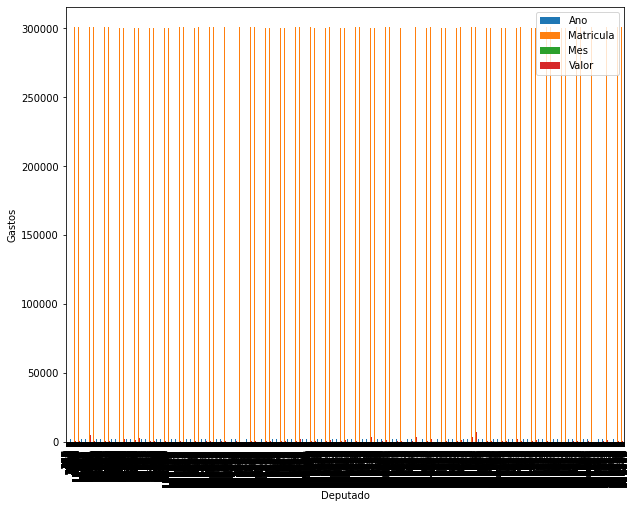

In [ ]:
dfalesp.plot.bar(figsize=(10,8),xlabel="Deputado",ylabel="Gastos")

In [ ]:
# removendo duplicatas
# b_df1.drop_duplicates()